# PSF Experiment Notebook - Galaxies w/o shape noise

This notebook contains the basic PSF test

2. Can AutoMetaCal perform better than ngmix by using the input PSFs for reconv? Using the PSF response...


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import galsim
import ngmix

from multiprocessing import Pool, freeze_support, cpu_count

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Test setup

In [3]:
#global values
fixnoise = True
batch_size=1000
scale= .2
stamp_size = 51
rng = np.random.RandomState(31415)
real_shear = [0.01,0.0]
noise_level = 1e-4

### Data

In [4]:
#dataset
data= tfds.load('simple/small_100k_noshear')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

Display a range of galaxy models:

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
labels = onebatch['label'] 

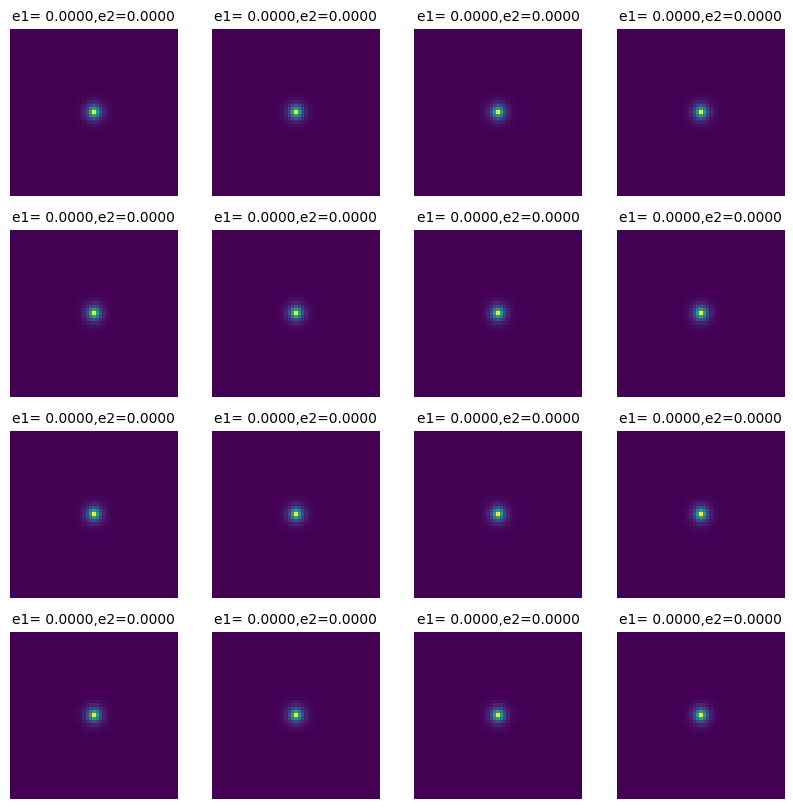

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

We transform these models by:
1. Adding a constant shear
3. Convolving with a PSF
2. Adding some noise

Both 1 and 2 are taken care by the noiseless_real_mcal_image function developed for the LearnR project.

In [7]:
#create 1 batch of observed images
psf_fwhm = 0.7
psf = galsim.Moffat(beta=5.0, fwhm=psf_fwhm).shear(g1=.05,g2=.0)
psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
psf_images = tf.repeat(psf_image,batch_size,axis=0)



gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([real_shear],
                                        len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])
gal_images += noise

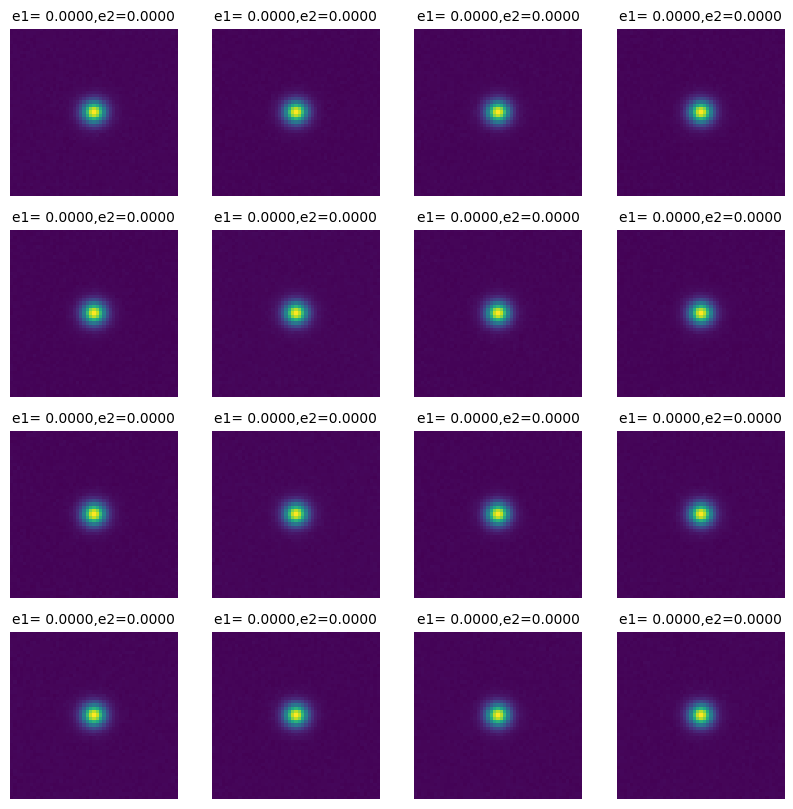

In [8]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin= 'lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

## Set up ngmix

In [9]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [10]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements

METACAL_TYPES = ['noshear',
                 '1p','1m','2p','2m',
                 '1p_psf','1m_psf','2p_psf','2m_psf']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='dilate',
  types=METACAL_TYPES,
  fixnoise=fixnoise,
)

Set up functions to get responses from AMC and ngmix

In [11]:
#for ngmix
def get_metacal_response_ngmix(resdict):
  step=0.01

  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
  
  #shear
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['e1'], resdict['1p_psf']['e2']])
  g1m_psf = np.array([resdict['1m_psf']['e1'], resdict['1m_psf']['e2']])
  g2p_psf = np.array([resdict['2p_psf']['e1'], resdict['2p_psf']['e2']])
  g2m_psf = np.array([resdict['2m_psf']['e1'], resdict['2m_psf']['e2']])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [12]:
def get_metacal_response_ngmix2(resdict):
  step=0.01

  e1, e2 = resdict['noshear']['g'], resdict['noshear']['g']
  
  #shear
  g0s = np.array([resdict['noshear']['g'][0], resdict['noshear']['g'][1]])
  g1p = np.array([resdict['1p']['g'][0], resdict['1p']['g'][1]])
  g1m = np.array([resdict['1m']['g'][0], resdict['1m']['g'][1]])
  g2p = np.array([resdict['2p']['g'][0], resdict['2p']['g'][1]])
  g2m = np.array([resdict['2m']['g'][0], resdict['2m']['g'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['g'][0], resdict['1p_psf']['g'][1]])
  g1m_psf = np.array([resdict['1m_psf']['g'][0], resdict['1m_psf']['g'][1]])
  g2p_psf = np.array([resdict['2p_psf']['g'][0], resdict['2p_psf']['g'][1]])
  g2m_psf = np.array([resdict['2m_psf']['g'][0], resdict['2m_psf']['g'][1]])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [13]:
def generate_mcal_image(gal_images,
                        psf_images,
                        reconvolution_psf_image,
                        g, gp,
                        padfactor=3):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)  
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)  
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  
  #Get batch info
  batch_size, nx, ny = gal_images.get_shape().as_list()  
      
  #add pads in real space
  fact = (padfactor - 1)//2 #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
    
  padded_gal_images = tf.pad(gal_images,paddings)
  padded_psf_images = tf.pad(psf_images,paddings)
  padded_reconvolution_psf_image = tf.pad(reconvolution_psf_image,paddings)
    
  #Convert galaxy images to k space
  im_shift = tf.signal.ifftshift(padded_gal_images,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, tf.complex64)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  
  #Convert psf images to k space  
  psf_complex = tf.cast(padded_psf_images, tf.complex64)
  psf_fft = tf.signal.fft2d(psf_complex)
  psf_fft_abs = tf.abs(psf_fft)
  psf_fft_abs_complex = tf.cast(psf_fft_abs,tf.complex64)
  kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  #Convert reconvolution psf image to k space 
  rpsf_complex = tf.cast(padded_reconvolution_psf_image, tf.complex64)
  rpsf_fft =  tf.signal.fft2d(rpsf_complex)
  rpsf_fft_abs = tf.abs(rpsf_fft)
  psf_fft_abs_complex = tf.cast(rpsf_fft_abs,tf.complex64)
  krpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  # Compute Fourier mask for high frequencies
  # careful, this is not exactly the correct formula for fftfreq
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,padfactor*nx),
                       tf.linspace(-0.5,0.5,padfactor*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)
  
  # Deconvolve image from input PSF
  im_deconv = imk * ( (1./(kpsf+1e-10))*mask)

  # Apply shear to the  deconv image
  im_sheared = gf.shear(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]  

  # Apply shear to the  kpsf image
  kpsf_sheared = gf.shear(tf.expand_dims(krpsf,-1), gp[...,0], gp[...,1])[...,0]    
  
  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * kpsf_sheared * mask))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  return img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]

In [14]:
def get_metacal_response(gal_images,
                         psf_images,
                         reconvolution_psf_image,
                         method):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gs = tf.zeros([batch_size, 4])
  epsf = method(reconvolution_psf_image)
  with tf.GradientTape() as tape:
    tape.watch(gs)
    # Measure ellipticity under metacal
    e = method(generate_mcal_image(gal_images,
                                   psf_images,
                                   psf_images,
                                   gs[:,0:2],gs[:,2:4]))
    
  # Compute response matrix

  Rs = tape.batch_jacobian(e, gs)
  R, Rpsf = Rs[...,0:2], Rs[...,2:4]
  return e, epsf, R, Rpsf

In [15]:
#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return get_metacal_response(gal_images, psf_images,psf_images,method)

## Shakedown Test!

Let's make a measurement on a single image.

In [16]:
im = gal_images[0]
psf_im = psf_images[0] 

In [17]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

Run one ngmix measurement:

In [18]:
resdict, obsdict = boot.go(obs)

In [19]:
true = real_shear

#ngmix calibration
ellips, R_ngmix, R_psf_ngmix = get_metacal_response_ngmix(resdict)
calibrated_ngmix = linalg.inv(R_ngmix) @ (ellips['noshear']) - (R_psf_ngmix @ array([0.05,0]) )

e_amc, e_psf, R_auto, R_psf = response(im[tf.newaxis], psf_im[tf.newaxis])
calibrated_amc = linalg.inv(R_auto[0].numpy()) @ ( e_amc[0].numpy() - R_psf[0].numpy() @ e_psf[0].numpy())

In [20]:
print("True:")
print(f"e1={true[0]:.6f}, e2={true[1]:.6f}.")

print("\nngmix:")
print(f"e1={calibrated_ngmix[0]:.6f}, e2={calibrated_ngmix[1]:.6f}.")

print("\nAutoMetaCal")
print(f"e1={calibrated_amc[0]:.6f}, e2={calibrated_amc[1]:.6f}.")

True:
e1=0.010000, e2=0.000000.

ngmix:
e1=0.041615, e2=-0.001808.

AutoMetaCal
e1=-0.005956, e2=-0.001506.


## Model Fitting

In [21]:
T_range = [-1.0, 10.]
F_range = [-1.0, 2.]

g_prior = ngmix.priors.GPriorBA(sigma=0.1, rng=rng)
cen_prior = ngmix.priors.CenPrior(
    cen1=0, cen2=0, sigma1=scale, sigma2=scale, rng=rng,
)
T_prior = ngmix.priors.FlatPrior(minval=T_range[0], maxval=T_range[1], rng=rng)
F_prior = ngmix.priors.FlatPrior(minval=F_range[0], maxval=F_range[1], rng=rng)

prior = ngmix.joint_prior.PriorSimpleSep(
    cen_prior=cen_prior,
    g_prior=g_prior,
    T_prior=T_prior,
    F_prior=F_prior,
)

# fit using the levenberg marquards algorithm
fitter = ngmix.fitting.Fitter(model='exp', prior=prior)
# make parameter guesses based on a psf flux and a rough T
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
    rng=rng,
    T=.25,
    prior=prior,
)

# psf fitting with coelliptical gaussians
psf_ngauss = 1
psf_fitter = ngmix.fitting.CoellipFitter(ngauss=psf_ngauss)
# special guesser for coelliptical gaussians
psf_guesser = ngmix.guessers.CoellipPSFGuesser(rng=rng, ngauss=psf_ngauss)

# this runs the fitter. We set ntry=2 to retry the fit if it fails
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=10,
)
runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=10,
)

# this bootstraps the process, first fitting psfs then the object
boot = ngmix.bootstrap.Bootstrapper(
    runner=runner,
    psf_runner=psf_runner,
)

METACAL_TYPES = ['noshear',
                 '1p','1m','2p','2m',]#'1p_psf','1m_psf','2p_psf','2m_psf']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=METACAL_TYPES,
  fixnoise=fixnoise,
)

In [22]:
def get_metacal_response_ngmix2(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['g'][0], resdict['noshear']['g'][1]])
  g1p = np.array([resdict['1p']['g'][0], resdict['1p']['g'][1]])
  g1m = np.array([resdict['1m']['g'][0], resdict['1m']['g'][1]])
  g2p = np.array([resdict['2p']['g'][0], resdict['2p']['g'][1]])
  g2m = np.array([resdict['2m']['g'][0], resdict['2m']['g'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
  
  if '1p_psf' in resdict.keys():
    #PSF
    g1p_psf = np.array([resdict['1p_psf']['g'][0], resdict['1p_psf']['g'][1]])
    g1m_psf = np.array([resdict['1m_psf']['g'][0], resdict['1m_psf']['g'][1]])
    g2p_psf = np.array([resdict['2p_psf']['g'][0], resdict['2p_psf']['g'][1]])
    g2m_psf = np.array([resdict['2m_psf']['g'][0], resdict['2m_psf']['g'][1]])    

    R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
    R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
    R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
    R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  

    ellip_dict = {
      'noshear':g0s,
      '1p':g1p,
      '1m':g1m,
      '2p':g2p,
      '2m':g2m,
      '1p_psf':g1p_psf,
      '1m_psf':g1m_psf,
      '2p_psf':g2p_psf,
      '2m_psf':g2m_psf,    
    } 

    Rpsf = np.array(
      [[R11_psf,R12_psf],
       [R21_psf,R22_psf]])
    return ellip_dict, R, Rpsf
  else:
    ellip_dict = {
      'noshear':g0s,
      '1p':g1p,
      '1m':g1m,
      '2p':g2p,
      '2m':g2m, 
    }
    return ellip_dict, R   


In [23]:
ellist = []
R_list = []

for i in range(batch_size):
  im = gal_images[i]
  psf_im = psf_images[i]
  
  wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
  psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)
  
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  resdict, obsdict = boot.go(obs)
  ellips, R_ngmix = get_metacal_response_ngmix2(resdict)
  ellist.append(ellips['noshear'])
  R_list.append(R_ngmix)
  

In [24]:
mean(linalg.inv(array(R_list)),axis=0) @ mean(array(ellist),axis=0)

array([ 0.01022535, -0.00383348])

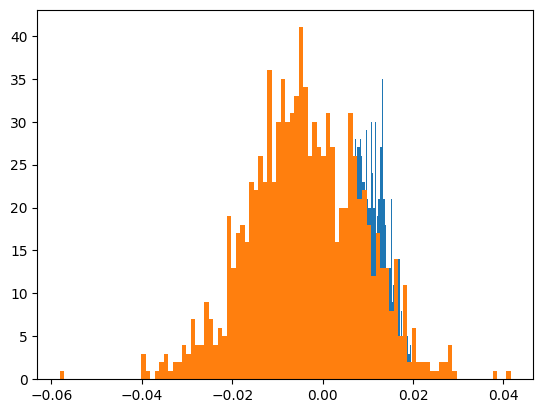

In [25]:
hist(array(ellist)[:,0],bins=100);
hist(array(ellist)[:,1],bins=100);

In [26]:
banana();

NameError: name 'banana' is not defined

## One Batch Test

In [ ]:
#reset data
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

In [ ]:
#get response and noshear ellipticities
e_amc, e_psf, R_auto, R_psf = response(gal_images, psf_images)
e_amc=tf.concat([e_amc],axis=0)
R_auto=tf.concat([R_auto],axis=0)

#averaging procedure
uncalibrated_shear_amc = tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]) - R_psf @ tf.reshape(e_psf,[-1,2,1]),axis=0)
calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(uncalibrated_shear_amc,[-1,2,1]),axis=0) 
calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(len(e_amc))

Testing AMC speed: 

To be fair, let's use ngmix in parallel. 

In [ ]:
#parallelisable function to map the data to
def response_ngmix(im_psf):
  im, psf = im_psf
  
  psf_obs = ngmix.Observation(
    psf,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  e_ngmix, R_ngmix = get_metacal_response_ngmix(resdict)
  
  return e_ngmix['noshear'], R_ngmix

from multiprocessing import Pool, freeze_support, cpu_count
pool = Pool(cpu_count()) 

In [ ]:
gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
psf_imlist = [psf_images[i] for i in range(len(gal_images))]
ims_psfs = zip(gal_imlist,psf_imlist)

Testing ngmix speed:

In [ ]:
t = time.time()
results = pool.map(response_ngmix, ims_psfs)
print(f"Finished in: {time.time()-t} s.")
pool.close()

In [ ]:
e_ngmix_list = [result[0] for result in results]
R_ngmix_list = [result[1] for result in results]

In [ ]:
calibrated_shear_ngmix = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ mean(array(e_ngmix_list),axis=0)
calibrated_shear_ngmix_err = linalg.inv(mean(array(R_ngmix_list),axis=0)) @ std(array(e_ngmix_list),axis=0)/sqrt(batch_size)

In [ ]:
print("True:")
print(f"e1={real_shear[0]:.6f}, e2={real_shear[1]:.6f}.")

print("\nUncalibrated shear estimation over 1k")
print(f"e1={uncalibrated_shear_amc[0]:.6f}, e2={uncalibrated_shear_amc[1]:.6f}.")

print("\nAutoMetaCal shear estimation over 1k")
print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")

print("\nngmix shear estimation over 1k")
print(f"e1={calibrated_shear_ngmix[0]:.6f}, e2={calibrated_shear_ngmix[1]:.6f}.")

## Multiple Shears to get a real estimate of m, c

In [ ]:
def single_field(shear,psf_ellip,nbatches,batchit):
  g1, g2 = shear
  g1psf, g2psf = psf_ellip
 
  noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])
  
  e_amc = []
  e_psf = []
  R_auto = []
  R_psf = []
  e_ngmix_list = []
  R_ngmix_list = []
  R_psf_ngmix_list = []

  psf_fwhm = 0.7
  psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=g1psf,g2=g2psf)
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,batch_size,axis=0).numpy()

  for _ in range(nbatches):
    onebatch = batchit.next()

    #prepare batch
    gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],psf_images,#psf_images here represent the true, noiseless psf
                              tf.repeat([[g1,g2]],len(onebatch['gal_model']),axis=0))

    noise = np.random.normal(scale=noise_level,size=[len(gal_images),51,51])

    gal_images += noise
    psf_images += noise/1000 #psf_images here are a measured model of the true psf 

    #run amc
    e_amc_batch, e_psf_batch, R_auto_batch, R_psf_batch = response(gal_images, psf_images)
    #gather amc results
    e_amc.append(e_amc_batch)
    e_psf.append(e_psf_batch)
    R_auto.append(R_auto_batch)
    R_psf.append(R_psf_batch)


    #prepare list for parallel map
    gal_imlist = [gal_images.numpy()[i] for i in range(len(gal_images))]
    psf_imlist = [psf_images[i] for i in range(len(gal_images))]
    ims_psfs = zip(gal_imlist,psf_imlist)

    #start and run parallel pool
    pool = Pool(cpu_count()//2)
    results = pool.map(response_ngmix, ims_psfs)
    pool.close()

    #append ngmix results
    e_ngmix_list += [result[0] for result in results]
    R_ngmix_list += [result[1] for result in results]
    R_psf_ngmix_list += [result[2] for result in results] 

  e_amc=tf.concat(e_amc,axis=0)
  e_psf = tf.concat(e_psf,axis=0)
  R_auto=tf.concat(R_auto,axis=0)
  R_psf=tf.concat(R_psf,axis=0)
    
  return e_amc, e_psf, R_auto, R_psf, e_ngmix_list, R_ngmix_list, R_psf_ngmix

def estimate_g_amc(e_amc,e_psf,R_auto,R_psf):
  uncalibrated_shear_amc = tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]) - R_psf @ tf.reshape(e_psf,[-1,2,1]),axis=0)
  calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(uncalibrated_shear_amc,[-1,2,1]),axis=0) 
  calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(len(e_amc))
 
  return uncalibrated_shear_amc, calibrated_shear_amc, calibrated_shear_amc_err

def estimate_g_ngmix(e_ngmix_list, e_psf_ngmix, R_ngmix_list, R_psf_ngmix):
  
  uncalibrated_shear_amc = tf.reduce_mean(tf.reshape(e_amc,[-1,2,1]) - R_psf @ tf.reshape(e_psf,[-1,2,1]),axis=0)
  calibrated_shear_amc = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.reduce_mean(tf.reshape(uncalibrated_shear_amc,[-1,2,1]),axis=0) 
  calibrated_shear_amc_err = tf.linalg.inv(tf.reduce_mean(R_auto[:],axis=0)) @ tf.math.reduce_std(tf.reshape(e_amc,[-1,2,1]),axis=0)/sqrt(len(e_amc))
 
  return uncalibrated_shear_ngmix, calibrated_shear_ngmix, calibrated_shear_ngmix_err

In [ ]:
noise_level = 1e-4
data = data.repeat()
batchit = data.as_numpy_iterator()
shearlist = linspace(-.025,.025,2,dtype='float32')

In [ ]:
psf_ellip = [0.0,0.0]
guncalib = []
gcalib = []
gcaliberr = []
epsflist = []
for shear in tqdm.tqdm(shearlist):
  shears = [shear,0.0]
  nbatches = 1
  e_amc, e_psf, R_auto, R_psf = single_field(shears,psf_ellip,nbatches,batchit)
  

  uncalibrated_shear_amc, calibrated_shear_amc, calibrated_shear_amc_err = estimate_g_amc(
    e_amc,
    e_psf,
    R_auto,
    R_psf)
  
  guncalib.append(uncalibrated_shear_amc)
  gcalib.append(calibrated_shear_amc)
  gcaliberr.append(calibrated_shear_amc_err)
  print("True:")
  print(f"e1={shears[0]:.6f}, e2={shears[1]:.6f}.")

  print("\nUncalibrated shear estimation over 10k")
  print(f"e1={uncalibrated_shear_amc.numpy()[0,0]:.6f}, e2={uncalibrated_shear_amc.numpy()[1,0]:.6f}.")

  print("\nAutoMetaCal shear estimation over 10k")
  print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")
  
  save("guncalib.npy",guncalib)
  save("gcalib.npy",gcalib)
  save("gcaliberr.npy",gcaliberr)

In [ ]:
mean(e_psf[:,0].numpy().flatten())

In [ ]:
psf_ellip = [0.01,0.0]
guncalib1 = []
gcalib1 = []
gcaliberr1 = []
for shear in tqdm.tqdm(shearlist):
  shears = [shear,0.0]
  nbatches = 1
  e_amc, e_psf, R_auto, R_psf = single_field(shears,psf_ellip,nbatches,batchit)

  uncalibrated_shear_amc, calibrated_shear_amc, calibrated_shear_amc_err = estimate_g_amc(
    e_amc,tf.repeat(tf.convert_to_tensor([psf_ellip]),batch_size,axis=0),R_auto,R_psf)
  
  guncalib1.append(uncalibrated_shear_amc)
  gcalib1.append(calibrated_shear_amc)
  gcaliberr1.append(calibrated_shear_amc_err)
  print("True:")
  print(f"e1={shears[0]:.6f}, e2={shears[1]:.6f}.")

  print("\nUncalibrated shear estimation over 10k")
  print(f"e1={uncalibrated_shear_amc.numpy()[0,0]:.6f}, e2={uncalibrated_shear_amc.numpy()[1,0]:.6f}.")

  print("\nAutoMetaCal shear estimation over 10k")
  print(f"e1={calibrated_shear_amc[0,0]:.6f}, e2={calibrated_shear_amc[1,0]:.6f}.")
  
  save("guncalib1.npy",guncalib1)
  save("gcalib1.npy",gcalib1)
  save("gcaliberr1.npy",gcaliberr1)

In [ ]:
style.use('ggplot')

In [ ]:
errorbar(shearlist,array(gcalib)[...,0][:,0]-shearlist,array(gcaliberr)[...,0][:,0],fmt=".",label="circular psf")
xlabel("g true")
ylabel("residual")
errorbar(shearlist,array(gcalib1)[...,0][:,0]-shearlist,array(gcaliberr1)[...,0][:,0],fmt=".",label="elliptical psf")
xlabel("$g_{1,true}$")
ylabel("$g_{1,obs}-g_{1,true}$")
legend()
title("circular vs. elliptical psfs correction test")
savefig(f"psf_test_zero{time.time()}.png",bbox_inches="tight")

In [ ]:
def get_metacal_response(gal_images,
                         psf_images,
                         reconvolution_psf_image,
                         method):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gs = tf.zeros([batch_size, 4])

  with tf.GradientTape() as tape:
    tape.watch(gs)
    # Measure ellipticity under metacal
    e = method(generate_mcal_image(gal_images,
                                   psf_images,
                                   psf_images,
                                   gs[:,0:2],gs[:,2:4]))
    epsf = method(psf_images)
  # Compute response matrix

  Rs = tape.batch_jacobian(e, gs)
  R, Rpsf = Rs[...,0:2], Rs[...,2:4]
  return e, epsf, R, Rpsf


def get_metacal_response_psf(gal_images,
                         psf_images,
                         reconvolution_psf_image,
                         method):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gs = tf.zeros([batch_size, 4])

  with tf.GradientTape() as tape:
    tape.watch(gs)
    # Measure ellipticity under metacal
    e = method(generate_mcal_image(gal_images,
                                   psf_images,
                                   psf_images,
                                   gs[:,0:2],gs[:,2:4]))
    epsf = method(psf_images)
  # Compute response matrix

  Rs = tape.batch_jacobian(e, gs)
  R, Rpsf = Rs[...,0:2], Rs[...,2:4]
  return e, epsf, R, Rpsf

## Varying the PSF test

In this test we will progressively shear the psf and observe how the residual m changes.